In [1]:
import numpy as np
import pandas as pd

from statsmodels.stats import proportion

import itertools
import re

import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set_style('white')
sbn.set_palette('muted', 10)

%matplotlib inline

C:\Users\Ted\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def define_words(alphabet, n):
    return [''.join(x) for x in itertools.product(alphabet, repeat=n)]

def replace_rare_base(s, rare_base='A'):
    return ''.join([c if (c is rare_base or c is '-') else 'X' for c in s ])

def get_nonrare_words(L, rare_base='A'):
    # This only works for non-dash sequences right now.
    n = len(L[0])
    
    words = define_words([rare_base, 'X'], n)
    counts = {w: 0 for w in words}
    res = {w: re.compile(w) for w in words}
    
    for s in L:
        mod_s = replace_rare_base(s, rare_base=rare_base)
        for w in words:
            # try using regexes? might not be faster than simple comps though...
            if res[w].search(mod_s):
                counts[w] +=1
    
    return counts

In [3]:
words_3 = define_words(['A', 'X'], 3)
good_words_3 = ['AAA', 'XAA', 'XXA', 'XXX']
bad_words_3 = ['AAX', 'AXA', 'AXX', 'XAX']

words_5 = define_words(['A', 'X'], 5)
good_words_5 = ['AAAAA', 'XAAAA', 'XXAAA', 'XXXAA', 'XXXXA', 'XXXXX']
bad_words_5 = ['AAAAX', 'AAAXA', 'AAAXX', 'AAXAA', 'AAXAX', 'AAXXA', 'AAXXX', 'AXAAA',
               'AXAAX', 'AXAXA', 'AXAXX', 'AXXAA', 'AXXAX', 'AXXXA', 'AXXXX', 'XAAAX',
               'XAAXA', 'XAAXX', 'XAXAA', 'XAXAX', 'XAXXA', 'XAXXX', 'XXAAX', 'XXAXA',
               'XXAXX', 'XXXAX']

# Load Data

In [4]:
data_path = """D:/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2016_03_24/TC/"""

word_f_range_3 = range(199, 205+1)
t_range = np.array([0, 2, 5, 15, 30, 60, 120])

data_3 = []
data_nodash_3 = []

for i in word_f_range_3:
    with open(data_path+'words_%i.txt' % i) as f:
        # Do full sequence loading
        data_3.append([line.strip() for line in f.readlines()])
        
        # Do no-dash, full extension stuff
        data_nodash_3.append([line for line in data_3[-1] if '-' not in line])

In [5]:
data_path = """D:/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2016_03_24/TC/"""

word_f_range_5 = range(206, 212+1)
t_range = np.array([0, 2, 5, 15, 30, 60, 120])

data_5 = []
data_nodash_5 = []

for i in word_f_range_5:
    with open(data_path+'words_%i.txt' % i) as f:
        # Do full sequence loading
        data_5.append([line.strip() for line in f.readlines()])
        
        # Do no-dash, full extension stuff
        data_nodash_5.append([line for line in data_5[-1] if '-' not in line])

# Generate Dfs, CIs
## Data

In [6]:
counts_3 = [get_nonrare_words(L) for L in data_nodash_3]
counts_3_df = pd.DataFrame()

counts_3_df['Time'] = t_range
for word in define_words(['A', 'X'], 3):
    counts_3_df[word] = [ct[word] for ct in counts_3]

rates_3_df = counts_3_df.div(counts_3_df[[c for c in counts_3_df.columns if c != 'Time']].sum(axis=1), axis=0)
rates_3_df.Time = counts_3_df.Time

In [7]:
counts_5 = [get_nonrare_words(L) for L in data_nodash_5]
counts_5_df = pd.DataFrame()

counts_5_df['Time'] = t_range
for word in define_words(['A', 'X'], 5):
    counts_5_df[word] = [ct[word] for ct in counts_5]

rates_5_df = counts_5_df.div(counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1), axis=0)
rates_5_df.Time = counts_5_df.Time

In [8]:
counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1)

0    7449
1    4752
2    8706
3    4989
4    4755
5    4191
6    2094
dtype: int64

## CI's

In [9]:
ci_3_df = pd.DataFrame()
for w in words_3:
    lb, ub = proportion.proportion_confint(counts_3_df[w], counts_3_df.sum(axis=1))
    ci_3_df['%s_lb' % w] = lb
    ci_3_df['%s_ub' % w] = ub
    
ci_5_df = pd.DataFrame()
for w in words_5:
    lb, ub = proportion.proportion_confint(counts_5_df[w], counts_5_df.sum(axis=1))
    ci_5_df['%s_lb' % w] = lb
    ci_5_df['%s_ub' % w] = ub

# 3 bp Words

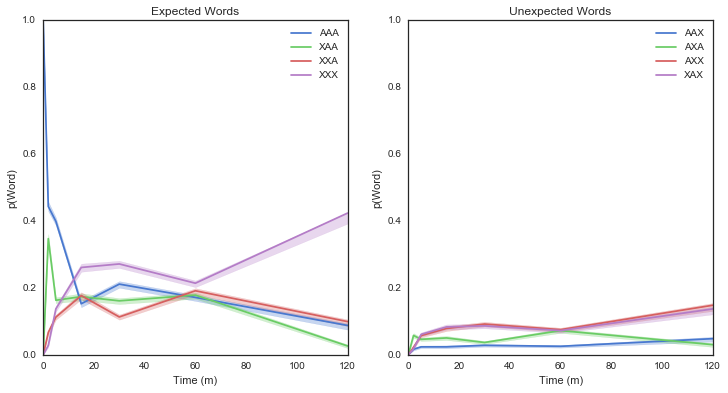

In [10]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.title('Expected Words')
for good_word in good_words_3:
    h = plt.plot(rates_3_df.Time, rates_3_df[good_word])
    plt.fill_between(rates_3_df.Time, 
                     ci_3_df['%s_lb' % good_word], ci_3_df['%s_ub' % good_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend()
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.subplot(1,2,2)
plt.title('Unexpected Words')
for bad_word in bad_words_3:
    h = plt.plot(rates_3_df.Time, rates_3_df[bad_word])
    plt.fill_between(rates_3_df.Time, 
                     ci_3_df['%s_lb' % bad_word], ci_3_df['%s_ub' % bad_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend()
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.savefig('3site_good_bad.png')
plt.show()

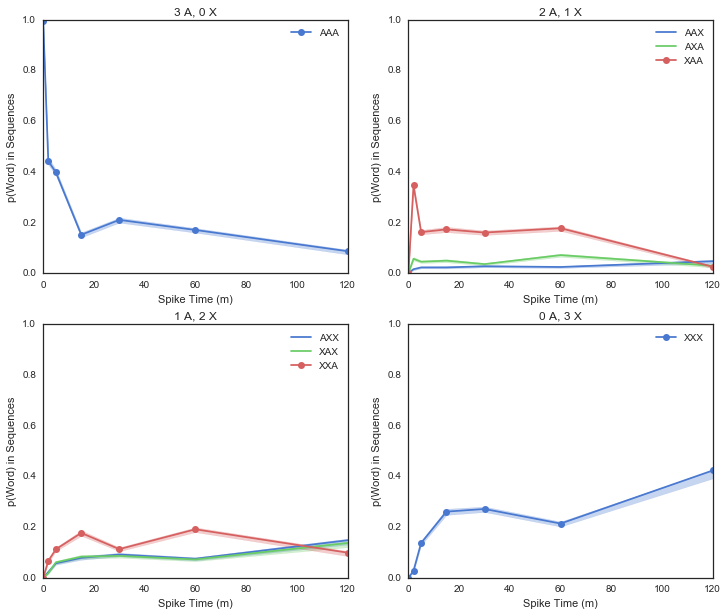

In [11]:
n_letters = 3

plt.figure(figsize=[12,10])
for i in range(0,n_letters+1):
    plt.subplot(2,2,n_letters+1-i)
    plt.title('%i A, %i X' % (i, n_letters-i))
    for w in words_3:
        if w.count('A') == i:
            if w in good_words_3:
                h = plt.plot(rates_3_df.Time, rates_3_df[w], 'o-')
            else:
                h = plt.plot(rates_3_df.Time, rates_3_df[w])
            plt.fill_between(rates_3_df.Time, 
                 ci_3_df['%s_lb' % w], ci_3_df['%s_ub' % w], 
                 color=h[0].get_color(), alpha=0.3)

    plt.legend()
    plt.axis([0, 120, 0, 1])
    plt.xlabel('Spike Time (m)')
    plt.ylabel('p(Word) in Sequences')

plt.savefig('3site_words.png')    
plt.show()

In [12]:
rates_3_df

,Time,AAA,AAX,AXA,AXX,XAA,XAX,XXA,XXX
0,0,0.994447,0.001745,0.001111,0.000000,0.002697,0.000000,0.000000,0.000000
1,2,0.443125,0.016620,0.057846,0.022664,0.347075,0.018131,0.066695,0.027844
2,5,0.398629,0.023775,0.046237,0.057322,0.162923,0.061114,0.112602,0.137398
3,15,0.152469,0.023805,0.050364,0.078694,0.173716,0.083219,0.176864,0.260870
4,30,0.211108,0.028299,0.036774,0.091858,0.161168,0.086410,0.113045,0.271338
5,60,0.171429,0.025446,0.072321,0.075149,0.178274,0.072321,0.191220,0.213839
6,120,0.087629,0.048211,0.030321,0.147968,0.026380,0.137053,0.099151,0.423287


In [13]:
pA = rates_3_df['AAA'].iloc[6] ** (1./3)
print (pA, 1-pA)
print (pA ** 3, pA ** 2 * (1-pA), pA * (1-pA) ** 2, (1-pA)** 3)

(0.44416983800187559, 0.55583016199812441)
(0.087628865979381451, 0.10965797901123096, 0.13722501400003223, 0.171722154986829)


In [14]:
from scipy.stats import chisquare

# 5 bp Words

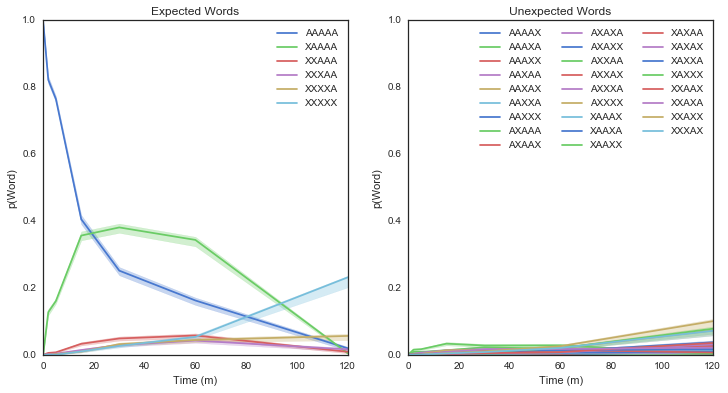

In [15]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.title('Expected Words')
for good_word in good_words_5:
    h = plt.plot(rates_5_df.Time, rates_5_df[good_word])
    plt.fill_between(rates_3_df.Time, 
                     ci_5_df['%s_lb' % good_word], ci_5_df['%s_ub' % good_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend()
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.subplot(1,2,2)
plt.title('Unexpected Words')
for bad_word in bad_words_5:
    h = plt.plot(rates_5_df.Time, rates_5_df[bad_word])
    plt.fill_between(rates_5_df.Time, 
                     ci_5_df['%s_lb' % bad_word], ci_5_df['%s_ub' % bad_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend(ncol=3)
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.savefig('5site_good_bad.png')
plt.show()

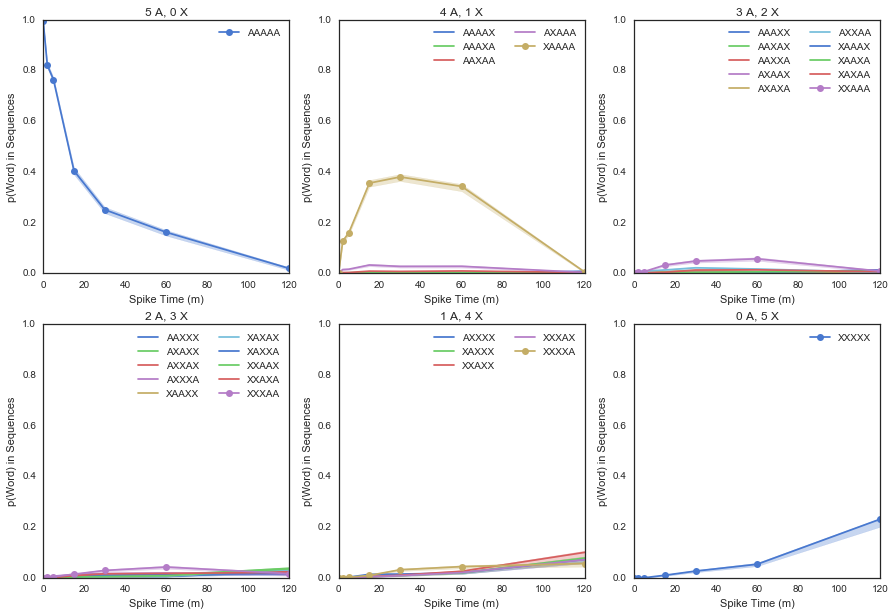

In [16]:
plt.figure(figsize=[15,10])
for i in range(0,5+1):
    plt.subplot(2,3,6-i)
    plt.title('%i A, %i X' % (i, 5-i))
    for w in words_5:
        if w.count('A') == i:
            if w in good_words_5:
                h = plt.plot(rates_5_df.Time, rates_5_df[w], 'o-')
            else:
                h = plt.plot(rates_5_df.Time, rates_5_df[w])
            plt.fill_between(rates_5_df.Time, 
                 ci_5_df['%s_lb' % w], ci_5_df['%s_ub' % w], 
                 color=h[0].get_color(), alpha=0.3)

    plt.legend(ncol=2)
    plt.axis([0, 120, 0, 1])
    plt.xlabel('Spike Time (m)')
    plt.ylabel('p(Word) in Sequences')
    
plt.savefig('5site_words.png')
plt.show()

# Old-style plots

In [17]:
def get_pos_cts(L, letter_order=['C','T','G','A']):
    n = len(L[0])
    cts = pd.DataFrame(np.zeros((n, len(letter_order))), columns=letter_order)
    
    for i in range(n):
        v = [w[i] for w in L]
        for c in letter_order:
            cts[c][i] = v.count(c)
    
    return cts    

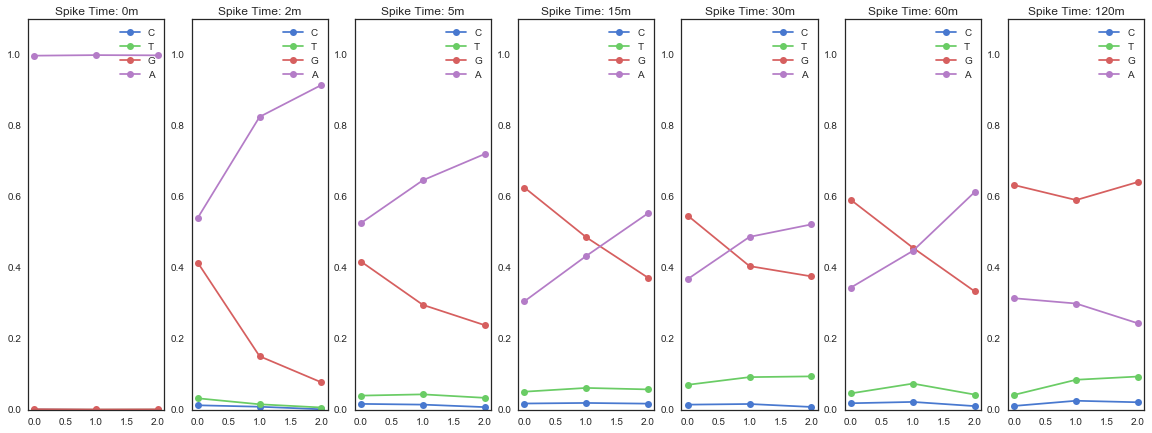

In [20]:
plt.figure(figsize=[20,7])
for i in range(len(data_nodash_3)):
    d = get_pos_cts(data_nodash_3[i])
    
    plt.subplot(1,7,i+1)
    for c in d.columns:
        plt.plot(d[c].div(d.sum(axis=1)), 'o-', label=c)
    plt.axis([-0.1, 2.1, 0, 1.1])
    plt.legend()
    plt.title('Spike Time: %im' % t_range[i])
    
plt.savefig('3site_locrate.png')
plt.show()

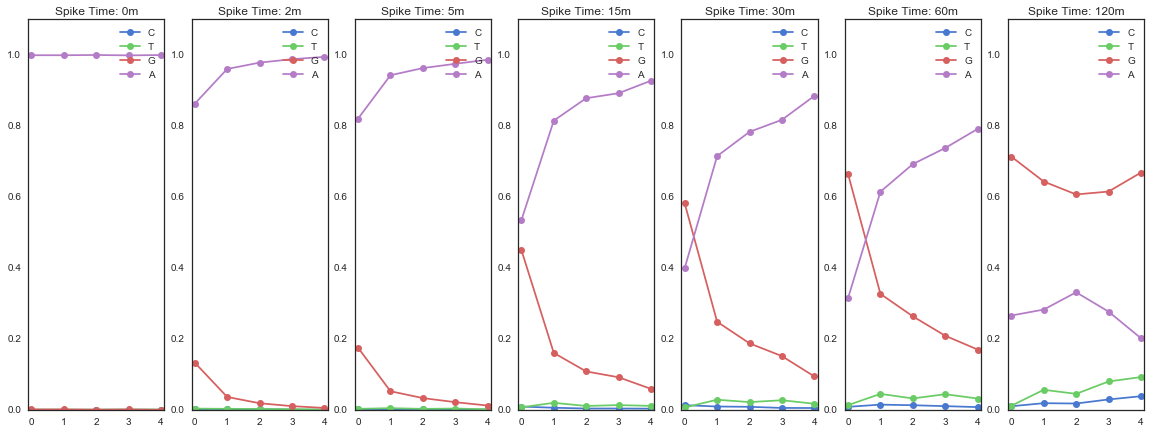

In [21]:
plt.figure(figsize=[20,7])
for i in range(len(data_nodash_5)):
    d = get_pos_cts(data_nodash_5[i])
    
    plt.subplot(1,7,i+1)
    for c in d.columns:
        plt.plot(d[c].div(d.sum(axis=1)), 'o-', label=c)
    plt.axis([-0.1, 4.1, 0, 1.1])
    plt.legend()
    plt.title('Spike Time: %im' % t_range[i])
plt.savefig('5site_locrate.png')
plt.show()

# Controls (Aggregate)

Should be noted, at some point, we need to look at per-strand data as well, especially for positional independence

In [13]:
import nextgenanalyze as nga
import ngsCSVAnalyze as ngscsv

In [14]:
idx = 176
fname = 'D:/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2016_03_24/TC/exp%i_run%i_misinc_data.csv' % (idx, idx)
foo = pd.read_csv(fname, index_col=0)

In [15]:
statsdf = ngscsv.getstats(foo)
print statsdf.describe()

       rate            lb            ub      n
count   0.0  1.000000e+02  1.000000e+02  100.0
mean    NaN  1.541333e-03  9.984587e-01    0.0
std     NaN  2.397261e-18  8.926529e-16    0.0
min     NaN  1.541333e-03  9.984587e-01    0.0
25%     NaN  1.541333e-03  9.984587e-01    0.0
50%     NaN  1.541333e-03  9.984587e-01    0.0
75%     NaN  1.541333e-03  9.984587e-01    0.0
max     NaN  1.541333e-03  9.984587e-01    0.0


## gBlocks

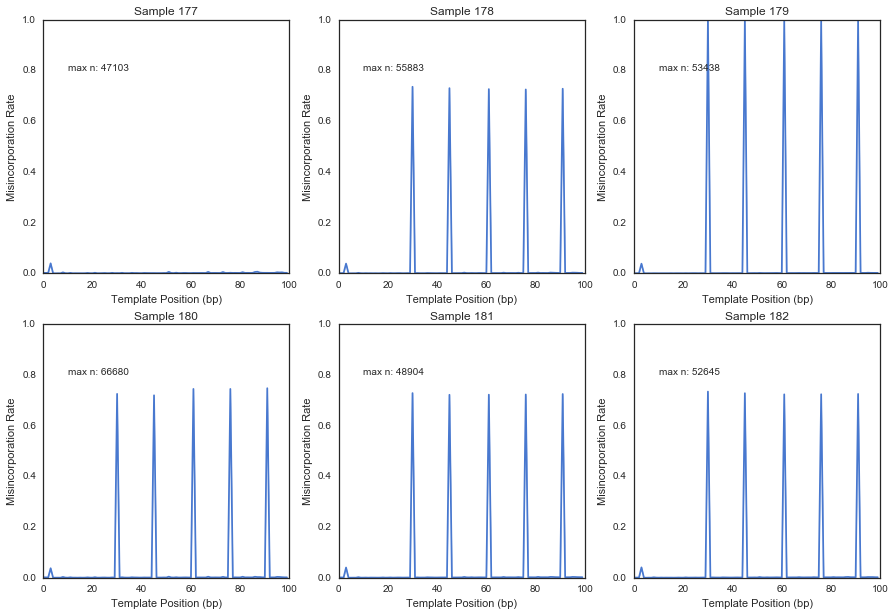

In [17]:
gBlock_idx = range(177, 183)

plt.figure(figsize=(15,10))
for i, idx in enumerate(gBlock_idx):
    df = pd.read_csv(data_path + 'exp%i_run%i_misinc_data.csv' % (idx, idx))
    stats = ngscsv.getstats(df)
    
    plt.subplot(2, 3, i+1)
    h = plt.plot(stats.rate)
    plt.fill_between(stats.index, stats.lb, stats.ub, 
                 color=h[0].get_color(), alpha=0.3)
    plt.text(10, 0.8, 'max n: %i' % max(stats.n))
    plt.title('Sample %i' % idx)
    plt.axis([0, 100, 0, 1])
    plt.xlabel('Template Position (bp)')
    plt.ylabel('Misincorporation Rate')
    
plt.savefig('gBlock_pos.png')

In [24]:
idx = 178

fname = 'D:/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2016_03_24/TC/exp%i_run%i_misinc_data.csv' % (idx, idx)
foo = pd.read_csv(fname, index_col=0)
statsdf = ngscsv.getstats(foo)
print statsdf[statsdf.rate > 0.01]

        rate        lb        ub        n sequence
3   0.038500  0.036928  0.040121  55792.0        C
30  0.735601  0.731930  0.739249  55787.0        A
45  0.730060  0.726364  0.733732  55779.0        A
61  0.726202  0.722490  0.729891  55782.0        A
76  0.724726  0.721008  0.728420  55788.0        A
91  0.727563  0.723856  0.731247  55756.0        A


## Annealed, 3-site (no column, then column)

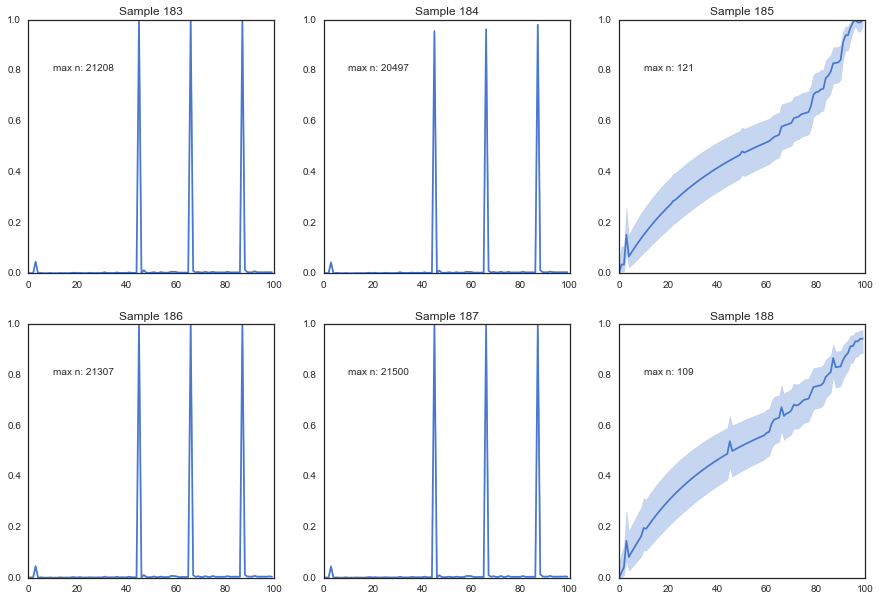

In [34]:
anneal_3_idx = range(183, 189)

plt.figure(figsize=(15,10))
for i, idx in enumerate(anneal_3_idx):
    df = pd.read_csv(data_path + 'exp%i_run%i_misinc_data.csv' % (idx, idx))
    stats = ngscsv.getstats(df)
    
    plt.subplot(2, 3, i+1)
    h = plt.plot(stats.rate)
    plt.fill_between(stats.index, stats.lb, stats.ub, 
                 color=h[0].get_color(), alpha=0.3)
    plt.text(10, 0.8, 'max n: %i' % max(stats.n))
    plt.title('Sample %i' % idx)
    plt.axis([0, 100, 0, 1])
plt.savefig('3site_annealed.png')

## Annealed 5-site (no column, then column)

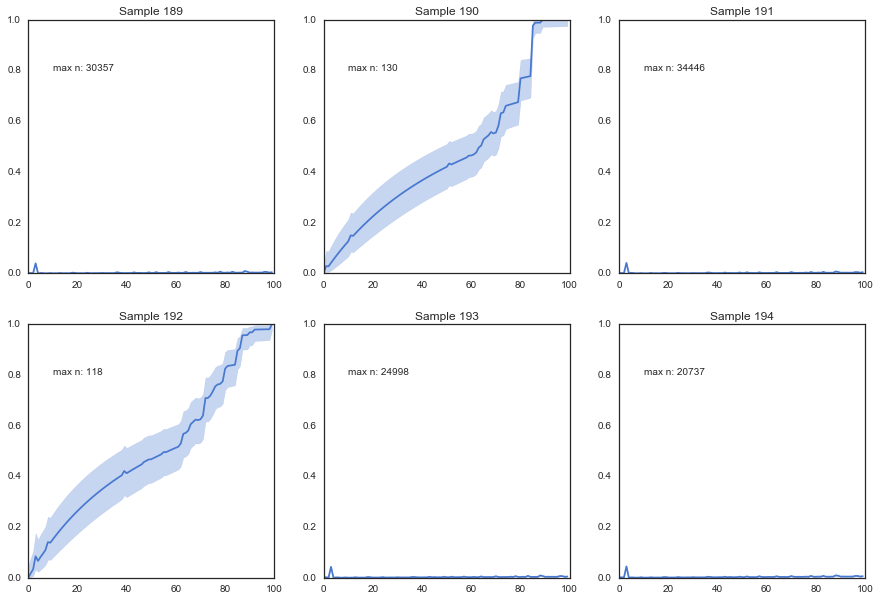

In [33]:
anneal_5_idx = range(189, 195)

plt.figure(figsize=(15,10))
for i, idx in enumerate(anneal_5_idx):
    df = pd.read_csv(data_path + 'exp%i_run%i_misinc_data.csv' % (idx, idx))
    stats = ngscsv.getstats(df)
    
    plt.subplot(2, 3, i+1)
    h = plt.plot(stats.rate)
    plt.fill_between(stats.index, stats.lb, stats.ub, 
                 color=h[0].get_color(), alpha=0.3)
    plt.text(10, 0.8, 'max n: %i' % max(stats.n))
    plt.title('Sample %i' % idx)
    plt.axis([0, 100, 0, 1])
plt.savefig('5site_annealed.png')

## Alex's one-site controls

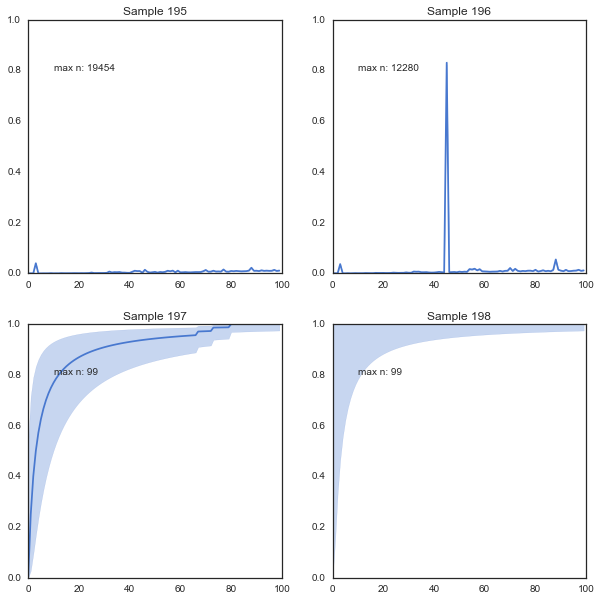

In [36]:
one_site_idx = range(195, 199)

plt.figure(figsize=(10,10))
for i, idx in enumerate(one_site_idx):
    df = pd.read_csv(data_path + 'exp%i_run%i_misinc_data.csv' % (idx, idx))
    stats = ngscsv.getstats(df)
    
    plt.subplot(2, 2, i+1)
    h = plt.plot(stats.rate)
    plt.fill_between(stats.index, stats.lb, stats.ub, 
                 color=h[0].get_color(), alpha=0.3)
    plt.text(10, 0.8, 'max n: %i' % max(stats.n))
    plt.title('Sample %i' % idx)
    plt.axis([0, 100, 0, 1])
    
plt.savefig('1site_location.png')

In [38]:
df_err = pd.read_csv(data_path + 'exp%i_run%i_misinc_data.csv' % (196, 196))
df_no_err = pd.read_csv(data_path + 'exp%i_run%i_misinc_data.csv' % (195, 195))

In [40]:
df_err[].iloc[45]

Unnamed: 0      45
C->C             0
C->A             0
C->T             0
C->G             0
A->C           310
A->A          2007
A->T           887
A->G          8605
T->C             0
T->A             0
T->T             0
T->G             0
G->C             0
G->A             0
G->T             0
G->G             0
sequence         A
Name: 45, dtype: object

In [224]:
df_no_err.iloc[45]

Unnamed: 0       45
C->C              0
C->A              0
C->T              0
C->G              0
A->C              2
A->A          19381
A->T              4
A->G              5
T->C              0
T->A              0
T->T              0
T->G              0
G->C              0
G->A              0
G->T              0
G->G              0
sequence          A
Name: 45, dtype: object

# Controls (by word)

Effectively, we want to see that we don't see anything too wacky in the word analysis.

In [27]:
import ngsMultiExtract as ngsme

sites_3 = [45, 66, 87]
sites_5 = [30, 45, 61, 76, 91]

## gBlock Positional Controls

In [28]:
gBlock_idx = range(177, 183)
gBlock_results = {}

for i, idx in enumerate(gBlock_idx):
    words = ngsme.get_positions(data_path + 'aln_seqs_run%i_exp%i.fa' % (idx, idx),
                                sites_5, keep_dashes=False)
    words = [replace_rare_base(w) for w in words]
    unique_words = list(set(words))
    
    gBlock_results[idx] = {}
    for w in unique_words:
        gBlock_results[idx][w] = words.count(w)

In [29]:
template_seqs = ['AAAAA', 'XXXXX', 'AAXXX']
results_dict = gBlock_results

for key in results_dict:
    print '*** Sample %i ***' % key
    
    total = float(sum(results_dict[key].values()))
    delivered = 0
    good = 0
    bad = 0
    
    for w in results_dict[key]:
        if w not in results_dict[key]:
            pass
        elif w in [s for s in good_words_5 if s not in template_seqs]:
            good += results_dict[key][w]
        elif w not in template_seqs:
            bad += results_dict[key][w]
            
    for w in template_seqs:
        print '%s: %i (rate: %f)' % (w, results_dict[key][w], results_dict[key][w] / total)
        delivered += results_dict[key][w]
            
    print 'Good: %i (rate: %f)' % (good, good / total)
    print 'Bad: %i (rate: %f)' % (bad, bad / total)

*** Sample 177 ***
AAAAA: 46893 (rate: 0.998276)
XXXXX: 2 (rate: 0.000043)
AAXXX: 1 (rate: 0.000021)
Good: 19 (rate: 0.000404)
Bad: 59 (rate: 0.001256)
*** Sample 178 ***
AAAAA: 10852 (rate: 0.194746)
XXXXX: 36085 (rate: 0.647567)
AAXXX: 848 (rate: 0.015218)
Good: 4037 (rate: 0.072446)
Bad: 3902 (rate: 0.070024)
*** Sample 179 ***
AAAAA: 1 (rate: 0.000019)
XXXXX: 53219 (rate: 0.999549)
AAXXX: 1 (rate: 0.000019)
Good: 1 (rate: 0.000019)
Bad: 21 (rate: 0.000394)
*** Sample 180 ***
AAAAA: 12538 (rate: 0.188598)
XXXXX: 43347 (rate: 0.652031)
AAXXX: 2560 (rate: 0.038508)
Good: 3968 (rate: 0.059687)
Bad: 4067 (rate: 0.061176)
*** Sample 181 ***
AAAAA: 9603 (rate: 0.197021)
XXXXX: 31052 (rate: 0.637082)
AAXXX: 993 (rate: 0.020373)
Good: 3611 (rate: 0.074085)
Bad: 3482 (rate: 0.071439)
*** Sample 182 ***
AAAAA: 10480 (rate: 0.199680)
XXXXX: 34041 (rate: 0.648598)
AAXXX: 754 (rate: 0.014366)
Good: 3753 (rate: 0.071508)
Bad: 3456 (rate: 0.065849)


C:\Users\Ted\Anaconda\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


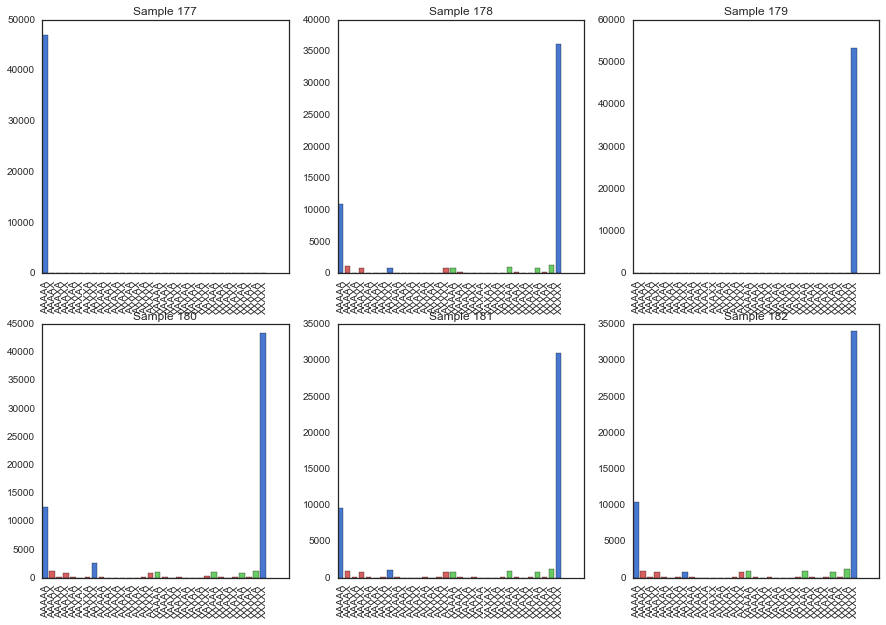

In [30]:
results_dict = gBlock_results

words = words_5
good_words = good_words_5
template_seqs = ['AAAAA', 'XXXXX', 'AAXXX']
index = range(len(words))

index = np.arange(len(words))

colors = []
for w in words:
    if w in template_seqs:
        colors.append(sbn.color_palette()[0])
    elif w in good_words:
        colors.append(sbn.color_palette()[1])
    else:
        colors.append(sbn.color_palette()[2])


plt.figure(figsize=[15,10])
for i, key in enumerate(results_dict):
    subdict = results_dict[key]
    plt.subplot(2, 3, i + 1)
    vals = [subdict[w] if w in subdict else 0 for w in words]
    plt.bar(index, vals, color=colors)
    plt.title('Sample %i' % key)
    plt.xticks(index + 0.5, words, rotation='vertical')
    
plt.savefig('gBlock_words.png')

## 3-Site annealed controls

In [119]:
anneal_3_idx = range(183, 189)
anneal_3_results = {}

for i, idx in enumerate(anneal_3_idx):
    words = ngsme.get_positions(data_path + 'aln_seqs_run%i_exp%i.fa' % (idx, idx),
                                sites_3, keep_dashes=False)
    words = [replace_rare_base(w) for w in words]
    unique_words = list(set(words))
    
    anneal_3_results[idx] = {}
    for w in unique_words:
        anneal_3_results[idx][w] = words.count(w)

In [131]:
template_seqs = ['AAA', 'XXX']
results_dict = anneal_3_results

for key in results_dict:
    print '*** Sample %i ***' % key
    
    total = float(sum(results_dict[key].values()))
    delivered = 0
    good = 0
    bad = 0
    
    for w in results_dict[key]:
        if w not in results_dict[key]:
            pass
        elif w in [s for s in good_words_3 if s not in template_seqs]:
            good += results_dict[key][w]
        elif w not in template_seqs:
            bad += results_dict[key][w]
            
    for w in template_seqs:
        if w in results_dict[key]:
            print '%s: %i (rate: %f)' % (w, results_dict[key][w], results_dict[key][w] / total)
            delivered += results_dict[key][w]
            
    print 'Good: %i (rate: %f)' % (good, good / total)
    print 'Bad: %i (rate: %f)' % (bad, bad / total)

*** Sample 183 ***
AAA: 28 (rate: 0.001402)
XXX: 19830 (rate: 0.992642)
Good: 14 (rate: 0.000701)
Bad: 105 (rate: 0.005256)
*** Sample 184 ***
AAA: 329 (rate: 0.016760)
XXX: 18639 (rate: 0.949516)
Good: 63 (rate: 0.003209)
Bad: 599 (rate: 0.030515)
*** Sample 185 ***
AAA: 18 (rate: 1.000000)
Good: 0 (rate: 0.000000)
Bad: 0 (rate: 0.000000)
*** Sample 186 ***
AAA: 5 (rate: 0.000247)
XXX: 20252 (rate: 0.998570)
Good: 7 (rate: 0.000345)
Bad: 17 (rate: 0.000838)
*** Sample 187 ***
AAA: 12 (rate: 0.000589)
XXX: 20325 (rate: 0.997203)
Good: 3 (rate: 0.000147)
Bad: 42 (rate: 0.002061)
*** Sample 188 ***
AAA: 13 (rate: 0.764706)
XXX: 4 (rate: 0.235294)
Good: 0 (rate: 0.000000)
Bad: 0 (rate: 0.000000)


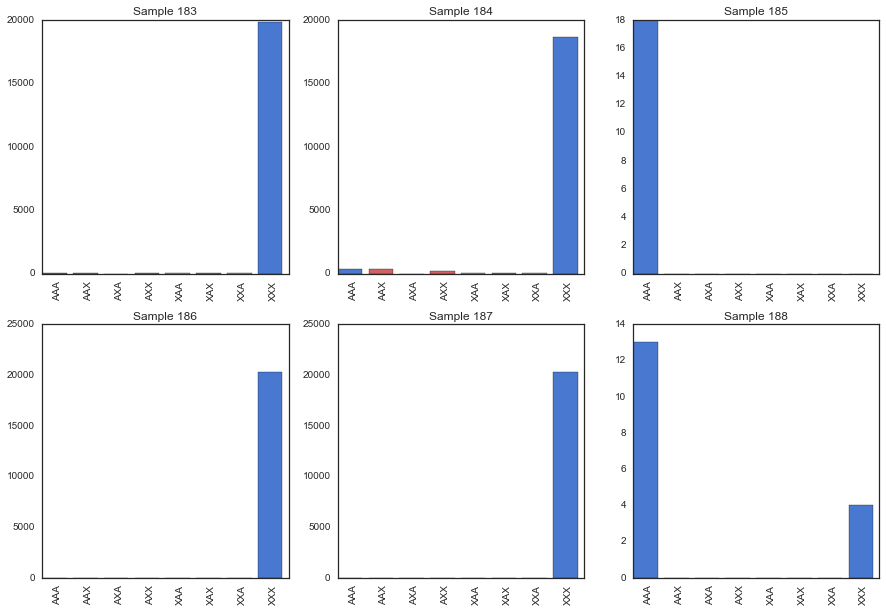

In [208]:
results_dict = anneal_3_results
words = words_3
good_words = good_words_3
template_seqs = ['AAA', 'XXX']

index = np.arange(len(words))

colors = []
for w in words:
    if w in template_seqs:
        colors.append(sbn.color_palette()[0])
    elif w in good_words:
        colors.append(sbn.color_palette()[1])
    else:
        colors.append(sbn.color_palette()[2])


plt.figure(figsize=[15,10])
for i, key in enumerate(results_dict):
    subdict = results_dict[key]
    plt.subplot(2, 3, i + 1)
    vals = [subdict[w] if w in subdict else 0 for w in words]
    plt.bar(index, vals, color=colors)
    plt.title('Sample %i' % key)
    plt.xticks(index + 0.5, words, rotation='vertical')

## 5-site Annealed Controls

In [123]:
anneal_5_idx = range(189, 195)
anneal_5_results = {}

for i, idx in enumerate(anneal_5_idx):
    words = ngsme.get_positions(data_path + 'aln_seqs_run%i_exp%i.fa' % (idx, idx),
                                sites_5, keep_dashes=False)
    words = [replace_rare_base(w) for w in words]
    unique_words = list(set(words))
    
    anneal_5_results[idx] = {}
    for w in unique_words:
        anneal_5_results[idx][w] = words.count(w)

In [133]:
template_seqs = ['AAAAA', 'XXXXX']
results_dict = anneal_5_results

for key in results_dict:
    print '*** Sample %i ***' % key
    if results_dict[key] == {}:
        print 'No sequences that match pattern.'
    else:
        total = float(sum(results_dict[key].values()))
        delivered = 0
        good = 0
        bad = 0

        for w in results_dict[key]:
            if w not in results_dict[key]:
                pass
            elif w in [s for s in good_words_5 if s not in template_seqs]:
                good += results_dict[key][w]
            elif w not in template_seqs:
                bad += results_dict[key][w]

        for w in template_seqs:
            if w in results_dict[key]:
                print '%s: %i (rate: %f)' % (w, results_dict[key][w], results_dict[key][w] / total)
                delivered += results_dict[key][w]

        print 'Good: %i (rate: %f)' % (good, good / total)
        print 'Bad: %i (rate: %f)' % (bad, bad / total)

*** Sample 192 ***
AAAAA: 2 (rate: 1.000000)
Good: 0 (rate: 0.000000)
Bad: 0 (rate: 0.000000)
*** Sample 193 ***
AAAAA: 23808 (rate: 0.996442)
XXXXX: 1 (rate: 0.000042)
Good: 18 (rate: 0.000753)
Bad: 66 (rate: 0.002762)
*** Sample 194 ***
AAAAA: 19736 (rate: 0.996013)
Good: 22 (rate: 0.001110)
Bad: 57 (rate: 0.002877)
*** Sample 189 ***
AAAAA: 28715 (rate: 0.995252)
Good: 27 (rate: 0.000936)
Bad: 110 (rate: 0.003813)
*** Sample 190 ***
No sequences that match pattern.
*** Sample 191 ***
AAAAA: 32962 (rate: 0.996825)
Good: 24 (rate: 0.000726)
Bad: 81 (rate: 0.002450)


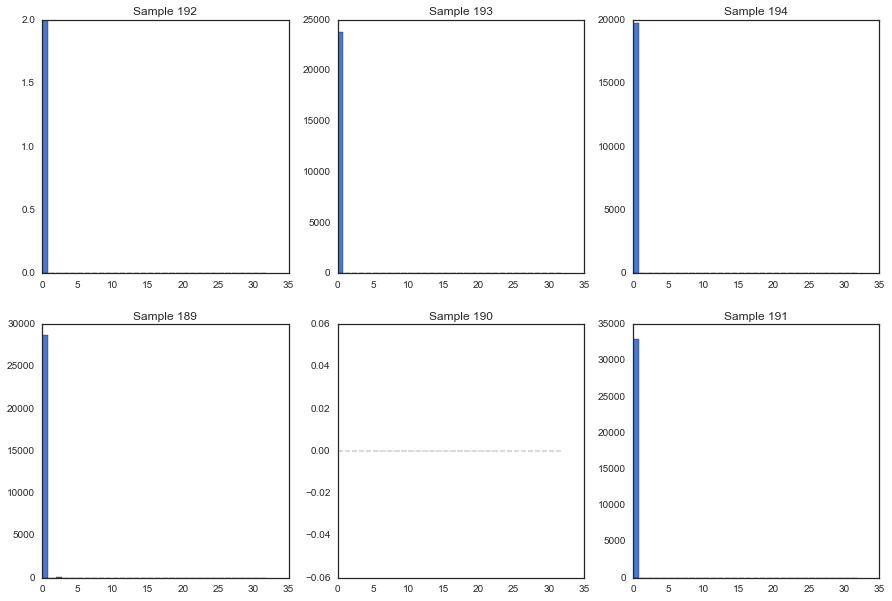

In [190]:
results_dict = anneal_5_results
words = words_5

index = range(len(words))

plt.figure(figsize=[15,10])
for i, key in enumerate(results_dict):
    subdict = results_dict[key]
    plt.subplot(2, 3, i + 1)
    vals = [subdict[w] if w in subdict else 0 for w in words]
    plt.bar(index, vals)
    plt.title('Sample %i' % key)